In [1]:
# Basics
from Solver import Particle, Perceptron, PerceptronModel, VicsekModel, NeuralNetwork, PerceptronMode, Mode, NeuralSwarmModel

import tensorflow   as tf
import numpy        as np
import os
import logging
import time

# Logging
# logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Allow for parallelization in both, tensorflow and the C++ backend (OMP)
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Simulation Environment
from tf_agents.trajectories     import time_step as ts
from tf_agents.specs            import array_spec
from tf_agents.environments     import py_environment

# Evaluation Environment
from tf_agents.networks         import network
from tf_agents.train.utils      import spec_utils
from tf_agents.environments     import tf_py_environment

# Environment Testing
from tf_agents.environments     import utils

# Critic Network
from tf_agents.agents.ddpg      import critic_network

# DDPG Agent
from tf_agents.agents.ddpg      import ddpg_agent
from tf_agents.train.utils      import train_utils

# Replay Buffer
import reverb
from tf_agents.replay_buffers   import reverb_replay_buffer
from tf_agents.replay_buffers   import reverb_utils

# Policies
from tf_agents.policies         import py_tf_eager_policy
from tf_agents.policies         import random_py_policy

# Actors
from tf_agents.train            import actor
from tf_agents.metrics          import py_metrics
from tf_agents.train            import learner

import tempfile

# Learner
from tf_agents.train            import triggers

# Plotting
import matplotlib.pyplot        as plt

2023-08-08 16:35:55.855856: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 16:35:55.883503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:35:56.302736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/renlephy/miniconda3/envs/bachelor/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/renlephy/mini

# Simulation Parameters

In [2]:
# Simulation settings
settings = {
        #                  N,      L,      v,      noise,  r
        "small": [         100,    10,     0.03,   0.1,    1]
    }
    
# Choose between RADIUS, FIXED, FIXEDRADIUS (don't use RADIUS)
mode = Mode.FIXEDRADIUS
# Flags
ZDimension = False     # 2D or 3D
seed = False           # Random seed
# Choose settings
chosen_settings = settings["small"]
N       = chosen_settings[0]
L       = chosen_settings[1]
v       = chosen_settings[2]
noise   = chosen_settings[3]
r       = chosen_settings[4]

k_neighbors = 5

# Hyperparameters
There are a lot of hyperparameters that can be tuned in a neural network, especially in a framework that allows for a lot of flexibility like TensorFlow. In this notebook, some of the hyperparameters are explored that can be tuned in a neural network (or agent- and RL-based framework) and how they affect the performance of the network. 

**However**, not all parameters that can be interpreted as hyperparameters are essential. TensorFlow has a lot of default values for parameters that are not essential to the network. Consequently, to retain readability but also offer TensorFlow's flexibility, hyperparameters are separated in **two blocks**.

1. Essential hyperparameters
2. Non-essential hyperparameters (default values)

### Essential hyperparameters
Essential hyperparameters are parameters that are essential to the network. These parameters are the ones that are most likely to be tuned in order to improve the performance of the network. These parameters are:

In [3]:
# Critic Network
observation_fc_layer_params     = (20,20)                       # @param {type:"tuple"}         - NO DEFAULT
action_fc_layer_params          = (20,)                         # @param {type:"tuple"}         - NO DEFAULT
joint_fc_layer_params           = (50,)                         # @param {type:"tuple"}         - NO DEFAULT
activation_fn                   = "relu"                        # @param {type:"string"}        - Default: "relu"
kernel_initializer              = "glorot_uniform"              # @param {type:"string"}        - Default: "glorot_uniform"
last_kernel_initializer         = "glorot_uniform"              # @param {type:"string"}        - Default: "glorot_uniform"

# DDPG Agent
actor_learning_rate             = 0.01                          # @param {type:"float"}         - Default: 0.001
actor_optimizer                 = tf.keras.optimizers.Adam(
    learning_rate=actor_learning_rate)                          #                               - NO DEFAULT
critic_learning_rate            = 0.01                          # @param {type:"float"}         - Default: 0.001
critic_optimizer                = tf.keras.optimizers.Adam(
    learning_rate=critic_learning_rate)                         #                               - NO DEFAULT
target_update_tau               = 1.0                           # @param {type:"float"}         - Default: 1.0
target_update_period            = 1                             # @param {type:"int"}           - Default: 1
td_errors_loss_fn = tf.math.squared_difference                  #                               - NO DEFAULT
gamma                           = 1.0                           # @param {type:"float"}         - Default: 1.0
reward_scale_factor             = 1.0                           # @param {type:"float"}         - Default: 1.0

# Replay Buffer
# Table
replay_buffer_capacity          = 100000                        # @param {type:"integer"}       - NO DEFAULT
sampler                         = reverb.selectors.Uniform()    #                               - NO DEFAULT
remover                         = reverb.selectors.Fifo()       #                               - NO DEFAULT
# Rate Limiter
samples_per_insert              = 1.0                           # @param {type:"float"}         - NO DEFAULT
min_size_to_sample              = 2                             # @param {type:"integer"}       - NO DEFAULT
error_buffer                    = samples_per_insert            # {float | Tuple[float, float]} - NO DEFAULT
# Saving and Sampling
sequence_length                 = 2                             # @param {type:"integer"}       - NO DEFAULT
batch_size                      = 1                             # @param {type:"integer"}       - NO DEFAULT
num_steps                       = 2                             # @param {type:"integer"}       - NO DEFAULT
num_prefetch                    = 1                             # @param {type:"integer"}       - NO DEFAULT

# Observer
observer_sequence_length        = 2                             # @param {type:"integer"}       - NO DEFAULT
observer_stride_length          = 1                             # @param {type:"integer"}       - Default: 1

# Actors
initial_collect_steps           = 2                             # @param {type:"integer"}       - NO DEFAULT
collector_steps_per_run         = 2                             # @param {type:"integer"}       - NO DEFAULT
eval_episodes_per_run           = 1                             # @param {type:"integer"}       - NO DEFAULT

# Learning Trigger
policy_save_interval            = 10                            # @param {type:"integer"}       - NO DEFAULT

# Training
num_iterations                  = 90                            # @param {type:"integer"}       - NO DEFAULT
eval_interval                   = 10                            # @param {type:"integer"}       - NO DEFAULT
log_interval                    = 10                            # @param {type:"integer"}       - NO DEFAULT
iterations_per_call             = 1                             # @param {type:"integer"}       - Default: 1

2023-08-08 16:35:57.334175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 16:35:57.365254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 16:35:57.365290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 16:35:57.369622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 16:35:57.369657: I tensorflow/compile

### Non-essential hyperparameters (default values)
These hyperparameters are not required to be set, but can be tuned to improve performance or test different configurations.
### (to be done)

# Simulation Environment

In [4]:
# Create a custom environment
class SimulationEnvironment(py_environment.PyEnvironment):
    """Interface for a swarm simulation environment.
    
    Can be converted into a TensorFlow environment.
    
    Provides uniform access to the simulation and hosts the reward function.
    """
    minimum = 0.0
    maximum = 2*np.pi
    
    def __init__(self):
        # The action is the angle of the particle
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.float32, minimum=self.minimum, maximum=self.maximum, name='action')
        
        
        # k_neighbors + 1 because the particle itself is also included
        # [ ] Change the observation to a relative angle (this reduces the dimensionality of the observation space by 1)
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(k_neighbors + 1,), dtype=np.float32, minimum=self.minimum, maximum=self.maximum, name='observation')
        
        # Flags and variables
        self._episode_ended = False
        self.simulation = NeuralSwarmModel(N, L, v, noise, r, mode, k_neighbors, ZDimension, seed=seed)
        self._state = self.simulation.mean_direction2D()
        # One "episode" and its corresponding reward consists of the iteration over all N particles
        self.index = 0
        # To change all angles at once, we need to store the new angles in a list
        self.new_angles = np.zeros(shape=(N,), dtype=np.float32)
        observation = self.simulation.get_angles(self.index)
        self._current_time_step = ts.restart(np.array(observation, dtype=np.float32))
        

    def observation_spec(self):
        """Return observation_spec."""
        # DONE
        return self._observation_spec

    def action_spec(self):
        """Return action_spec."""
        # DONE
        return self._action_spec
    
    def reset(self):
        """Return initial_time_step and reset the simulation.
        
        Note that this is a hard reset and not a reset for the current epoch."""
        
        # DONE
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        """Apply action and return new time_step."""
        # DONE
        if self._current_time_step is None:
            return self.reset()
        self._current_time_step = self._step(action)
        return self._current_time_step

    def current_time_step(self):
        # DONE
        return self._current_time_step

    # def time_step_spec(self):
        """Return time_step_spec."""
        # DONE
        # return ts.time_step_spec(self.observation_spec())

    def _reset(self):
        """Return initial_time_step and reset the simulation.
        
        Note that this is a hard reset."""
        # The episode ends when all particles have been updated. An epoch ends when the simulation is reset.
        # THOUGHTS: Epochs can't be implemented right now, since the simulation gets hard reset after every episode. (by the framework)
        # Reset simulation
        self.simulation = NeuralSwarmModel(N, L, v, noise, r, mode, k_neighbors, ZDimension, seed=False)
        self._state = self.simulation.mean_direction2D()
        self._episode_ended = False
        self.index = 0
        observation = self.simulation.get_angles(self.index)
        logger.info(f'Reset with observation = {observation}')
        return ts.restart(np.array(observation, dtype=np.float32))
    
    def _step(self, action):
        """Apply action and return new time_step.
        This method hosts the reward function."""

        logger.info(f'Step with action = {action}')
        # Check action boundaries
        action = np.clip(action, self.minimum, self.maximum)
        
        # Calculate the local order parameter before applying the action
        initial_order_param = self.simulation.get_local_order_parameter(self.index)
        
        # Update angle of the particle, but don't update the simulation yet
        self.new_angles[self.index] = action
        
        # Apply the action
        self.simulation.update_angle(self.index, action)
        
        # Calculate the local order parameter after applying the action
        final_order_param = self.simulation.get_local_order_parameter(self.index)
        
        # Calculate the reward as the signed difference of the order parameters
        reward = final_order_param - initial_order_param

        # Increment the index to the next particle
        self.index += 1
        
        # Create the observation
        observation = self.simulation.get_angles(self.index)
        observation = np.array(observation, dtype=np.float32)
        observation = np.where(observation < 0.0, 0.0, observation)  # Make sure observation is positive

        # Check validity of observation
        if np.isnan(observation).any():
            raise ValueError(f'The observation contains nan. Observation = {observation}.')
        elif np.any(observation < self.minimum) or np.any(observation > self.maximum):
            raise ValueError(f'The observation is not in the correct range. Observation = {observation}.')

        # Check if we've gone through all particles
        if self.index >= N - 1:
            self._episode_ended = True
            self.index = 0
            
            self.simulation.update()
            self._state = self.simulation.mean_direction2D()
            
            # We can add the state difference to the reward if needed
            # reward += self._state - oldState  # Uncomment this line if you want to add the global reward component
            logger.info(f'Episode ended with reward = {reward}')
            return ts.termination(observation, reward)

        logger.info(f'Step ended with reward = {reward}')
        return ts.transition(observation, reward=reward, discount=1.0)


![Environment Flowchart Functions](illustrations/environment_flowchart_functions_transparent.png)

# Strategies

With this option, the training can be scaled to multiple GPUs or TPUs, or multiple machines.

For this to work, two steps are necessary:

- The strategy has to be initialised.
- The model must be defined in a strategy scope.

In this project this option is not used, but it is included for completeness.

In [5]:
"""
from tf_agents.train.utils import strategy_utils

# Distribution strategy
# For now, don't use GPU or TPU

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=False)

# All variables and Agents need to be created under strategy.scope()
"""

"\nfrom tf_agents.train.utils import strategy_utils\n\n# Distribution strategy\n# For now, don't use GPU or TPU\n\nstrategy = strategy_utils.get_strategy(tpu=False, use_gpu=False)\n\n# All variables and Agents need to be created under strategy.scope()\n"

# Environment Wrapping

To ensure compatibility with the TensorFlow Agents (TF-Agents) framework, the code involves a necessary process of environment wrapping.

There are two distinct environments established, each tailored for different aspects of the training process:

## Training Environment (`collect_env`)

- **Purpose**: Primarily employed for training the agent.
- **Data Collection**: Retrieves interactions from the environment and stores them in a replay buffer, which serves as a repository of experience to train the agent.
- **Agent Updates**: Utilizes the critic network to compute the loss and refine the agent.
- **Characteristics**:
  - **Exploration**: Incorporates various strategies for data acquisition. It often integrates components such as noise to encourage the agent to explore novel actions.
  - **Action Handling**: May use action clipping to ensure the agent's actions are within permissible bounds.

## Evaluation Environment (`eval_env`)

- **Purpose**: Specifically designed for evaluating the agent's performance.
- **Performance Metrics**: Monitors how well the agent performs, ensuring an unbiased assessment by eliminating training-related components (like noise or exploration).
- **Characteristics**:
  - Operates without the aforementioned noise or exploration components to provide a clear view of the agent's capabilities in a given task.

Both environments undergo a wrapping process to make them seamlessly integrate with TensorFlow operations, thereby streamlining training and evaluation processes.


In [6]:
# There are two networks and two environments: one for training and one for evaluation.
collect_env = SimulationEnvironment()
eval_env = SimulationEnvironment()

# Wrap the environment in a TF environment.
tf_collect_env = tf_py_environment.TFPyEnvironment(collect_env)
tf_eval_env = tf_py_environment.TFPyEnvironment(eval_env)

# For the network to work with the environment, the specs have to be known.
observation_spec, action_spec, time_step_spec = (spec_utils.get_tensor_specs(tf_collect_env))

# Testing Checkpoint

In [7]:
# Test the python environments

print("Testing the python environments")
print("Testing the collect environment")
utils.validate_py_environment(collect_env, episodes=1)
print("Testing the eval environment")
utils.validate_py_environment(eval_env, episodes=1)

Testing the python environments
Testing the collect environment
Testing the eval environment


### YES! IT WORKS!

# Actor-Critic Networks

## Overview

DDPG (Deep Deterministic Policy Gradients) is a model-free, online, off-policy reinforcement learning method. The method uses a policy network (the Actor) to select actions and a value network (the Critic) to evaluate them. The given code provides the implementation of these two networks.

In [8]:
# Define a network that can learn to predict the action given an observation.
# This is a simple (on demand fully connected) network that takes in an observation and outputs an action.

class ActorNet(network.Network):

  def __init__(self, input_tensor_spec, output_tensor_spec, name='ActorNet'):
    super(ActorNet, self).__init__(
        input_tensor_spec=input_tensor_spec,
        state_spec=())
    self._output_tensor_spec = output_tensor_spec
    # THOUGHTS: For now, only one layer is used. This can be changed later.
    self._sub_layers = [
        tf.keras.layers.Dense(
            action_spec.shape.num_elements(), activation="linear"),
    ]

  def call(self, observations, step_type=(), network_state=()):
    del step_type  # unused.
    
    output = tf.cast(observations, dtype=tf.float32)
    for layer in self._sub_layers:
      output = layer(output)
    actions = tf.reshape(output, [-1] + self._output_tensor_spec.shape.as_list())

    # Scale and shift actions to the correct range if necessary.
    return actions, network_state


# Create the Actor Network
actor_net = ActorNet(
    input_tensor_spec=observation_spec,
    output_tensor_spec=action_spec)


# Critic Network
critic_net = critic_network.CriticNetwork(
      (observation_spec, action_spec),
      observation_fc_layer_params=observation_fc_layer_params,
      action_fc_layer_params=action_fc_layer_params,
      joint_fc_layer_params=joint_fc_layer_params,
      activation_fn=activation_fn,
      kernel_initializer=kernel_initializer,
      last_kernel_initializer=last_kernel_initializer)

# DONT USE AN ACTOR DISTRIBUTION NETWORK FOR DDPG AGENTS
# They need a deterministic action output. The actor distribution network is for stochastic policies. (like PPO or SAC)

## Code Explanation

### 1. Dependencies and Tools

```python
from tf_agents.agents.ddpg import critic_network
```

- We import the ``critic_network`` module, a predefined architecture for the Critic in DDPG from TensorFlow Agents.

### 2. Actor Network

![Actor Network](illustrations/actor_network_transparent.png)

The Actor network predicts the best possible action for a given state. Unlike other methods, in DDPG, this prediction is deterministic.

### Structure
```python
class ActorNet(network.Network):
```

- **Purpose**: Predict the optimal action for a given state.
- **Nature**: Deterministic. Always outputs the same action for the same state.
- **Architecture**:
    - Single fully connected layer (as of now).
    - Uses a linear activation function.

### Inner Workings

- The network gets an observation (state) and processes it through its internal layers.
- The output is reshaped to match the expected action's structure.
- If necessary, the action values are adjusted (scaled/shifted) to fit within the valid action range.

### 3. Critic Network
![Critic Network](illustrations/critic_network_transparent.png)

The Critic Network, in the context of DDPG, is used to estimate the Q-value of a state-action pair.

### Creation
```
critic_net = critic_network.CriticNetwork(...)
```

- **Input**: The network takes two inputs – an observation and an action.
- **Output**: Outputs a Q-value, estimating the expected return of that action in that state.

### Inner Workings

- Both the observation and the action are separately processed through their own neural network layers.
- The outputs from these separate branches are then combined.
- The combined output goes through one or more additional layers to produce the final Q-value estimate.

### Architectural Details
- **Initialization**: The network weights are initialized using the 'glorot_uniform' method, suitable for most deep learning scenarios.
- **Layers and Parameters**:
    - Separate layers for processing observations and actions.
    - Joint layers to process combined data.
    - Activation functions and other layer parameters can be adjusted for fine-tuning.

## Key Takeaway
It's essential to ensure that the Actor network in DDPG outputs deterministic actions. It should not be confused with other methods where the policy network might output a distribution over actions.

# Hyperparameters in the above code block
(all of these are optional; default values suffice)
- `observation_fc_layer_params`
- `action_fc_layer_params`
- `critic_joint_fc_layer_params`
- `activation_fn`
- `kernel_initializer`
- `last_kernel_initializer`

### Hyperparameters Explanation

- `observation_fc_layer_params`: Specifies the architecture (e.g., number of layers and their respective sizes) for the fully connected layers that process the observation (or state) input in the critic network.

- `action_fc_layer_params`: Dictates the architecture for the fully connected layers handling the action input in the critic network.

- `joint_fc_layer_params`: After processing the observation and action separately, their outputs are concatenated. This parameter sets the architecture for the subsequent fully connected layers that process this combined data.

- `kernel_initializer`: Determines the method for initializing the weights in the network layers. Proper initialization ensures effective training and convergence. The initializer affects all layers except the last one. ``'glorot_uniform'`` initializes weights randomly based on the number of input and output neurons. 

- `last_kernel_initializer`: Like the `kernel_initializer`, but specifically for the final layer of the network.


# Agent

In [9]:
# Initialize the agent

train_step = train_utils.create_train_step()

tf_agent = ddpg_agent.DdpgAgent(
    time_step_spec,
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.keras.optimizers.Adam(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.keras.optimizers.Adam(
        learning_rate=critic_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.math.squared_difference,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    train_step_counter=train_step)

tf_agent.initialize()

2023-08-08 16:35:58.644259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Choice of the right Agent

For this project, the DDPG algorithm was chosen. The main reason for this choice is that the DDPG algorithm is a good fit for continuous action spaces.

Other algorithms (for continuous action spaces) might be suitable as well. As a reference, the following figure provides an overview of the most common algorithms in reinforcement learning.

![RL Algorithms](illustrations/agents_overview_transparent.png)

### Code Explanation:

1. **Imports**:

```python
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.train.utils import train_utils
```
- These lines import necessary modules from TensorFlow's reinforcement learning library, TF-Agents.

1. **Training Step Initialization**:
```
train_step = train_utils.create_train_step()
```
  - A training step counter is created. This will keep track of how many training iterations (or steps) the agent has undergone. It's especially useful for logging, debugging, and scheduling (e.g., learning rate decay based on steps).

1. **Initializing the DDPG Agent**:

```
tf_agent = ddpg_agent.DdpgAgent(...)
```
  - This section initializes the DDPG (Deep Deterministic Policy Gradients) agent. The DDPG agent is an RL agent suitable for continuous action spaces.
  - Parameters:
    - `time_step_spec` & `action_spec`: Specifications ensuring compatibility between the agent's components and the environment.
    - `actor_network` & `critic_network`: Pre-defined actor and critic networks.
    - `actor_optimizer` & `critic_optimizer`: Optimization algorithms (Adam) for training the actor and critic networks. 
    - `target_update_tau` & `target_update_period`: Parameters controlling the soft update of target networks.
    - `td_errors_loss_fn`: The temporal difference (TD) error loss function. This function measures the difference between the estimated future rewards and the observed reward, using the squared difference.
    - `gamma`: Discount factor for future rewards.
    - `reward_scale_factor`: A factor to scale the magnitude of rewards.
    - `train_step_counter`: Earlier initialized training step counter.

1. **Agent Initialization**:

`tf_agent.initialize()`
  - This line initializes the agent, preparing it for the training process.


# Hyperparameters in the above code block
- `actor_optimizer`
  - `actor_learning_rate`
- `critic_optimizer`
  - `critic_learning_rate`
- `target_update_tau`
- `target_update_period`
- `td_errors_loss_fn`
- `gamma`
- `reward_scale_factor`

### About the Loss in Reinforcement Learning
In supervised learning, "loss" directly measures the difference between the predicted value and the actual value (e.g., how far off a predicted house price is from the actual price). In reinforcement learning, things are more indirect. The agent receives "rewards" from the environment based on actions it takes. Over time, it learns to maximize cumulative rewards.

However, to "learn," we typically use neural networks (or other function approximators) that need a scalar "loss" to perform optimization (i.e., adjust weights). The "loss" in RL is derived from the difference between expected rewards (Q-values from our networks) and the actual received rewards plus expected future rewards. In DDPG and similar algorithms, this is represented as the Temporal Difference (TD) error.

This "loss" is then backpropagated through the network to adjust the weights, allowing the agent to make better action choices in the future.

Overall, while the principles between supervised learning and RL are similar, in RL, the challenge and novelty lie in the fact that the "correct answer" (or immediate reward) might lead to sub-optimal long-term outcomes. Thus, the agent must learn to balance immediate and future rewards.

# Replay Buffer

In [10]:
# Use Reverb, a framework for experience replay developed by DeepMind, to store and sample experience tuples for training.
# Using a samples_per_insert somewhere between 2 and 1000. This is a trade-off between the number of samples that can be drawn from the replay buffer and the number of times the replay buffer needs to be updated.
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=samples_per_insert, min_size_to_sample=min_size_to_sample, error_buffer=error_buffer)

table_name = 'uniform_table'

table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=rate_limiter)

reverb_server = reverb.Server([table])

# Since the agent needs N steps of experience to make an update, the dataset will need to sample batches of N steps + 1 to allow the agent to learn from a complete transition.

reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=sequence_length,
    table_name=table_name,
    local_server=reverb_server)

# A dataset is created from the replay buffer to be fed to the agent for training. 
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=num_steps).prefetch(num_prefetch)

experience_dataset_fn = lambda: dataset

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpblobqddf.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpblobqddf
[reverb/cc/platform/default/server.cc:71] Started replay server on port 34397


# Replay Buffer with Reverb

Experience replay is a critical component in many reinforcement learning algorithms, primarily Deep Q-Networks (DQN) and its variants (like DDPG). It helps break the correlation between subsequent state-action-reward transitions, providing a more stable and smoother learning experience. Additionally, it enables the reuse of past experiences, increasing the data efficiency.

In the code provided, DeepMind's **Reverb** is employed for experience replay. Reverb is an efficient and easy-to-use system that can be used as a storage for experience. 


**Reverb Rate Limiter**: `rate_limiter=reverb.rate_limiters.SampleToInsertRatio(...)`
- This part of the code controls the rate at which items can be added to the buffer compared to the rate at which items are sampled. It's a mechanism to ensure the replay buffer remains diverse and doesn't get flooded with too many similar experiences in quick succession.
- The parameter `samples_per_insert` determines how many samples, on average, will be drawn from the replay buffer for each item that's inserted.

**Table Configuration**: 
- `table_name` simply gives a name to the Reverb table being created.
- The `reverb.Table` instance represents where the experiences will be stored.
  - `max_size` sets the capacity of the replay buffer.
  - The `sampler` defines a strategy for sampling experiences from the buffer. Here, a `Uniform` sampler is used, meaning that all experiences have an equal chance of being sampled.
  - The `remover` uses a FIFO (First-In-First-Out) strategy, meaning the oldest experiences will be removed first when the buffer reaches its capacity.
  - `rate_limiter` ensures that the sampling and inserting rates adhere to the specified rules.

**Reverb Server**: `reverb_server = reverb.Server([table])`
  - Reverb functions through a client-server architecture. Here, a server instance is started with the defined table.

**Reverb Replay Buffer**: `reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(...)`
- This integrates Reverb with the TF-Agents framework. It provides an interface for the agent to interact with the replay buffer.
- `sequence_length` determines how many consecutive items will be returned when sampling from the replay buffer. 

**Dataset Creation**: `dataset = reverb_replay.as_dataset(...)`
- This line translates the replay buffer into a TensorFlow dataset. This is crucial because it enables efficient batching and shuffling, and provides an easy-to-useformat to feed to the learning algorithm.
- `sample_batch_size` determines how many items (based on `sequence_length`) will be returned in each ``batch``.
- `num_steps` determines how many batches will be returned per sampling.
- `prefetch(50)` improves training throughput by preparing 50 batches in advance to minimize latency.
- The lambda function `experience_dataset_fn` is a simple utility to fetch this dataset, which can be used later for training iterations.


In the context of reinforcement learning, using such a buffer allows the agent to learn from a more diverse set of experiences, rather than just the most recent ones, making training more robust and data-efficient.

# Hyperparameters in the above code block

- `samples_per_insert`
- `min_size_to_sample`
- `error_buffer`
- `max_size` = `replay_buffer_capacity`
- `sampler` = `reverb.selectors.Uniform()`
- `remover` = `reverb.selectors.Fifo()`
- `rate_limiter` = `rate_limiter`
- `sequence_length`
- `sample_batch_size` = `batch_size`
- `num_steps`
- `Prefetch Value`


# Difference between ``sequence_length`` and ``num_steps``

Understanding the nuances between ``sequence_length`` and ``num_steps`` is essential when working with the Reverb replay system in the TF-Agents framework. These parameters control how data is stored and sampled, respectively.

### 1. Data Storage with ``sequence_length``:
  - When you set ``sequence_length=5``, the replay buffer will store experiences in chunks of 5 steps.
  - Each stored sequence in the buffer will contain these 5 steps.

### 2. Data Sampling with ``num_steps``:
  - If you try to sample with ``num_steps=3`` from a buffer storing sequences of 5 steps, you can potentially retrieve any 3-step sub-sequence from within the 5-step stored sequences.
  - This means you might get steps 1-3, 2-4, or 3-5, depending on the sampler strategy used.
  - With a uniform sampler, each possible 3-step sub-sequence has an equal chance of being sampled.

**Example Scenario**:

Imagine storing experiences in 5-step sequences. If you then try to sample using ``num_steps=6``, you'll likely encounter an error since the buffer does not contain sequences of that length. Conversely, when sampling with ``num_steps=3``, you can extract any contiguous 3-step sequence from the stored 5-step experiences.

It's crucial to set these parameters with clarity on their roles:

- ``sequence_length`` dictates how experiences are organized in storage.
- ``num_steps`` influences the way you sample from these stored experiences.

# Policies

In [11]:
# Policies
# Create policies from the agent

tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

# Random policy to sample from the environment
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

# Policies Summary

In the above code block, three distinct policies are created:

### 1. **Evaluation Policy (`eval_policy`):**
   - Extracted from the DDPG agent's internal evaluation policy (`tf_eval_policy`).
   - This policy is wrapped using `PyTFEagerPolicy`, which facilitates policy execution in TensorFlow's eager mode. Eager mode allows for more intuitive imperative execution, improving debugging and making the code more readable.

### 2. **Collection Policy (`collect_policy`):**
   - Derived from the DDPG agent's internal collection policy (`tf_collect_policy`).
   - Like the evaluation policy, this is also wrapped using `PyTFEagerPolicy`.
   - Notably, the exploration-exploitation trade-off inherent in this policy is already predefined within the DDPG agent's implementation. The wrapping into an eager policy does not modify these exploration aspects.

### 3. **Random Policy (`random_policy`):**
   - An entirely random policy that samples actions based on the environment's action specification.
   - Primarily used to initialize data collection, ensuring a diverse set of experiences at the start of training.

It's essential to recognize that the `PyTFEagerPolicy` wrapper serves primarily to enable eager execution and does not dictate or alter the exploration strategy of the underlying policy. That behavior is ingrained in the DDPG agent's implementation itself.


# Actors

In [12]:
tempdir = tempfile.gettempdir()

# Custom observer that counts and logs the number of times it is called.
class ProgressObserver:
    def __init__(self, total_steps, log_every=1):
        self.total_steps = total_steps
        self.log_every = log_every
        self.current_step = 0

    def __call__(self, trajectory):
        self.current_step += 1
        if self.current_step % self.log_every == 0:
            print(f"Initial collector step {self.current_step} of {self.total_steps}                    \r", end="")

progress_observer = ProgressObserver(total_steps=initial_collect_steps)

# As the Actors run data collection steps, they pass trajectories of (state, action, reward) to the observer, which caches and writes them to the Reverb replay system.

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=observer_sequence_length,
  stride_length=observer_stride_length)

# We create an Actor with the random policy and collect experiences to seed the replay buffer with.
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer, progress_observer])

initial_collect_actor.run()

# Instantiate an Actor with the collect policy to gather more experiences during training.
env_step_metric = py_metrics.EnvironmentSteps()

collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=collector_steps_per_run,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

# Create an Actor which will be used to evaluate the policy during training.
# actor.eval_metrics(num_eval_episodes) to log metrics later.
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=eval_episodes_per_run,
  metrics=actor.eval_metrics(eval_episodes_per_run),
  summary_dir=os.path.join(tempdir, 'eval'),
)

# Actors & Observer Summary

The provided code demonstrates the creation of actors and an observer in the context of the DDPG agent and Reverb replay system.

### 1. **Temporary Directory (`tempdir`):**
   - A directory path is acquired to temporarily store relevant information, such as metrics summaries.

### 2. **Reverb Observer (`rb_observer`):**
   - An instance of `ReverbAddTrajectoryObserver` is created.
   - As actors interact with their environments, they generate trajectories, which are sequences of (state, action, reward).
   - The observer's role is to cache these trajectories and write them into the Reverb replay system for future training.
   - It's set up to observe trajectories with a specified `sequence_length` and `stride_length`.

### 3. **Initial Collection Actor (`initial_collect_actor`):**
   - This actor uses the `random_policy`.
   - Its purpose is to interact with the environment and generate initial experiences. These are important for seeding the replay buffer, ensuring a diverse starting point for training.
   - After creation, the actor immediately starts running, thereby populating the replay buffer.
   - The generated trajectories are observed by the `rb_observer`.

### 4. **Training Collection Actor (`collect_actor`):**
   - Unlike the initial actor, this one employs the `collect_policy`.
   - It's designed to gather more refined experiences during training, as the agent learns and improves.
   - In addition to the `rb_observer`, this actor also updates an `env_step_metric`, which counts the environment steps taken. This can be useful for monitoring and diagnostics.
   - The summary of metrics related to data collection is stored in a directory specified by `os.path.join(tempdir, learner.TRAIN_DIR)`.

### 5. **Evaluation Actor (`eval_actor`):**
   - This actor uses the `eval_policy` and interacts with the evaluation environment (`eval_env`).
   - Its main purpose is to periodically assess the performance of the agent's policy during training.
   - Metrics related to evaluation (like average return over episodes) are logged and can be analyzed to monitor the agent's progress.
   - The summary of these evaluation metrics is stored in a directory specified by `os.path.join(tempdir, 'eval')`.

In essence, the actors are agents that interact with environments and generate experiences. The observer's role is to monitor these experiences and store them appropriately for training. Together, they ensure a seamless flow of information, enabling the agent to learn effectively from its interactions.


# Hyperparameters in the above code block
- ``observer_sequence_length``
- ``observer_stride_length``
- ``initial_collect_steps``
- ``collector_steps_per_run``
- ``eval_episodes_per_run``

# Learner

In [13]:
# Learners
# The Learner component contains the agent and performs gradient step updates to the policy variables using experience data from the replay buffer.
# After one or more training steps, the Learner can push a new set of variable values to the variable container.

saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000)
]

# A strategy can be used here. The predefined strategy would be passed to the learner.
agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (26518) so Table uniform_table is accessed directly without gRPC.


# Learner & Triggers Summary

This segment focuses on the creation and configuration of the `Learner` component within the DDPG training process.

### 1. **Learner Introduction:**
   - The `Learner` component is central to the training process. It encapsulates the agent and is responsible for executing gradient updates on the policy's parameters using experiences sourced from the replay buffer.
   - Post-training (after one or multiple steps), the `Learner` has the capability to update the set of variables within a designated container.

### 2. **Model Save Directory (`saved_model_dir`):**
   - A specific directory path is designated to save the policy's model. This is set as a sub-directory (`POLICY_SAVED_MODEL_DIR`) within the temporary directory (`tempdir`).

### 3. **Triggers (`learning_triggers`):**
   - Triggers are mechanisms to automate certain actions during the training process.
   - Two triggers are set up:
     - `PolicySavedModelTrigger`: This saves the agent's policy checkpoints at specified intervals (`policy_save_interval`). These checkpoints capture the policy's state, allowing for later resumption or analysis.
     - `StepPerSecondLogTrigger`: Designed to log training information, specifically how many training steps are executed per second. The logging occurs every 1000 steps.

### 4. **Instantiating the Learner (`agent_learner`):**
   - The `Learner` object is initialized with various configurations:
     - The temporary directory (`tempdir`), which serves as a location to save intermediate data.
     - The current training step (`train_step`), which keeps track of the progress.
     - The agent itself (`tf_agent`), which contains the policy and value network.
     - A function (`experience_dataset_fn`) that supplies experiences from the replay buffer.
     - The predefined triggers (`learning_triggers`) to automate specific tasks during training.

Together, the `Learner` and associated triggers ensure that the agent's policy is continually updated and refined using the stored experiences, while simultaneously maintaining checkpoints and logs for monitoring and potential resumption of training.


# Hyperparameters in the above code block
- ``policy_save_interval``

# Metrics and Evaluation

In [14]:
"""
We instantiated the eval Actor with actor.eval_metrics above, which creates most commonly used metrics during policy evaluation:

- Average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes.
- Average episode length.

We run the Actor to generate these metrics.
"""

def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -0.000000, AverageEpisodeLength = 99.000000


# Evaluation Metrics Summary

In the above segment, the focus is on generating and logging key evaluation metrics during the policy's performance assessment.

### 1. **Introduction to Eval Actor Metrics:**
   - The `eval_actor` was previously instantiated using `actor.eval_metrics`. This procedure automatically includes some commonly used metrics to evaluate the efficacy of the policy:
     - **Average Return**: It signifies the average sum of rewards accumulated while the policy operates within an environment over multiple episodes.
     - **Average Episode Length**: This measures the average duration of an episode, indicating how long the agent persists in the environment before reaching a terminal state.

### 2. **Metric Generation (`get_eval_metrics` function):**
   - The `eval_actor` runs to generate the aforementioned metrics.
   - A ``dictionary`` named `results` is populated with metric names as keys and their corresponding outcomes as values.

### 3. **Logging Metrics (`log_eval_metrics` function):**
   - Designed for a clear and structured display of the evaluation metrics.
   - The metrics are formatted as a string and then printed alongside the current training step, offering insights into the policy's performance at different stages of training.

### 4. **Executing Metric Collection and Logging:**
   - The `get_eval_metrics` function is invoked to obtain the evaluation metrics.
   - Using the `log_eval_metrics` function, these metrics are subsequently printed for the training step `0`.

Overall, these functions enable consistent monitoring of the policy's performance, ensuring that potential issues or areas of improvement are swiftly identified.


# Training the agent

In [15]:
# The training loop involves both collecting data from the environment and optimizing the agent's networks.
# Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]
losses = [0]

for _ in range(num_iterations):
  # Training.
  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_actor.run()
  # Sample a batch of data from the buffer and update the agent's network.
  loss_info = agent_learner.run(iterations=iterations_per_call)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])
    losses.append(loss_info.loss.numpy())
    

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

time.sleep(1)  # Give the last metrics log a second to flush.
print("Training completed. Closing the observer... ", end="")
# rb_observer.close()
print("Closed.")
time.sleep(1)  # Give the observer a second to flush.
print("Stopping the reverb server... ", end="")
reverb_server.stop()
print("stopped.")

2023-08-08 16:36:00.295954: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5074020fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-08 16:36:00.295979: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-08-08 16:36:00.299095: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-08 16:36:00.420263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-08 16:36:00.484026: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


step = 10: AverageReturn = 2.285831, AverageEpisodeLength = 98.000000
step = 10: loss = 0.029550224542617798
step = 20: AverageReturn = 2.711709, AverageEpisodeLength = 98.000000
step = 20: loss = 0.018632221966981888
step = 30: AverageReturn = 2.882915, AverageEpisodeLength = 98.000000
step = 30: loss = 0.022069504484534264
step = 40: AverageReturn = 2.917303, AverageEpisodeLength = 98.000000
step = 40: loss = 0.012488390319049358
step = 50: AverageReturn = 2.936764, AverageEpisodeLength = 98.000000
step = 50: loss = 0.002755116205662489
step = 60: AverageReturn = 2.945086, AverageEpisodeLength = 98.000000
step = 60: loss = 0.0008618539432063699
step = 70: AverageReturn = 2.945858, AverageEpisodeLength = 98.000000
step = 70: loss = 0.0041861766949296
step = 80: AverageReturn = 2.945858, AverageEpisodeLength = 98.000000
step = 80: loss = 0.005091051105409861
step = 90: AverageReturn = 2.945858, AverageEpisodeLength = 98.000000
step = 90: loss = 0.0005088158068247139
Training completed.

[reverb/cc/platform/default/server.cc:84] Shutting down replay server


# Training Loop Summary

This segment highlights the core procedure: executing the training loop, which involves collecting data, training the agent, and periodically evaluating its performance.

### 1. **Initial Setup:**
   - The agent's `train_step_counter` is reset to zero, ensuring that training begins afresh.
   - The agent's policy is evaluated before the training begins to provide a baseline. The initial average return value is obtained and stored.

### 2. **Main Training Loop (`for _ in range(num_iterations)`):**
   - For each iteration in the training loop:
     - **Data Collection**: The `collect_actor` runs, utilizing the `collect_policy` to gather experiences from the environment. These experiences are stored in the replay buffer.
     - **Network Training**: A batch of experiences is sampled from the replay buffer, and the agent's networks (Actor and Critic) are updated. The resultant loss information from this update is captured.

### 3. **Periodic Evaluation and Logging:**
   - The current training step is fetched.
   - If the step aligns with the defined `eval_interval`, the following actions take place:
     - The agent's policy is evaluated using `get_eval_metrics`.
     - These metrics are logged, and the average return value is added to the `returns` list.
     - The loss value from the most recent network update is also recorded in the `losses` list.
   - If the step matches the `log_interval`, the loss is printed, providing periodic insight into the agent's training progression.

### 4. **Closing Procedures:**
   - The `rb_observer` is closed, ensuring that no further experiences are added to the replay buffer.
   - The `reverb_server` (associated with the replay buffer) is also stopped, marking the end of the training process.

In essence, this segment captures the cyclical process of collecting experiences, training the agent on these experiences, and periodic evaluations to assess the agent's proficiency.


# Hyperparameters in the above code block
- ``num_iterations``
- ``iterations_per_call``
- ``eval_interval``
- ``log_interval``

# Plot the results

(1.8034533083438873, 3.0002582252025602)

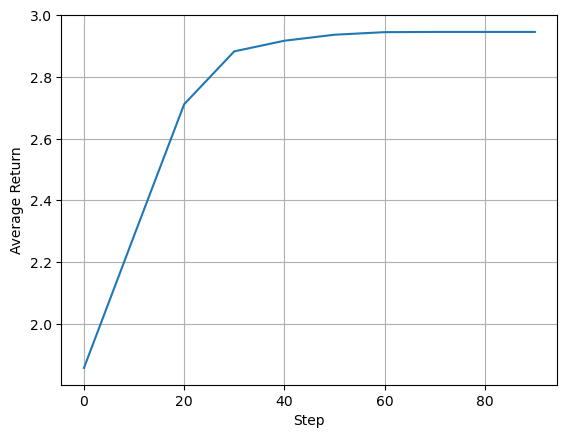

In [16]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.grid()
plt.ylim()

(-0.0009432546299649404, 0.03100229497940745)

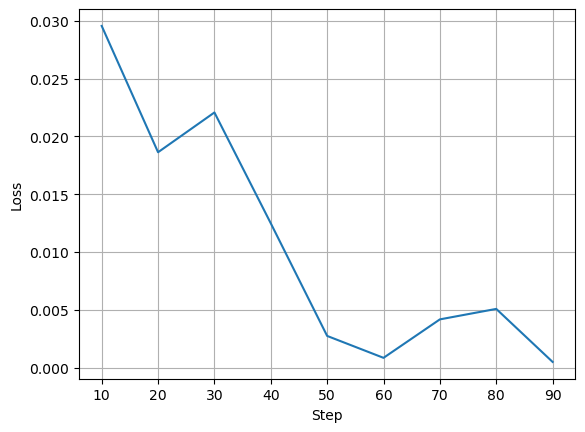

In [18]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps[1:], losses[1:])
plt.ylabel('Loss')
plt.xlabel('Step')
plt.grid()
plt.ylim()